In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from src.base_line import BaseLine
from src.exponenta import get_stat
from src.net_trend_bi import PredictTrendBi

In [28]:
from src.read_params import read_params

par1, par2, n_point, n_lev, trend, season_amp, season_fi, period = read_params(
    "src/params.yaml"
)

В функции sim_data сейчас используется экспонента. TODO: добавить в pipeline расчет линейной экспоненты

In [29]:
def sim_data(batch=16):
    num_point = np.random.randint(300) + 65
    # num_point = 1000
    x = torch.zeros(batch, num_point, 3, dtype=torch.float32)
    y = torch.zeros(batch, num_point, 1, dtype=torch.float32)

    n = 10
    num_lavel = np.random.randint(num_point - n) + n
    for i in range(batch):
        s1, s2, s3 = np.random.rand(), np.random.rand(), np.random.rand() * 2 * 3.14
        # trend = np.random.rand()*2 + 0.5
        r = np.random.randint(2)
        if r == 0:
            par = par1
        elif r == 1:
            par = par2

        t = BaseLine(
            params=par1,
            num_point=num_point,
            num_level=num_lavel,
            trend=trend,
            seasonality=(s1, s2, s3),
            period=365,
        )
        t.mask()
        x[i, :, 0] = torch.tensor(t.mask_out)
        x[i, :, 1] = torch.tensor(t.x)
        x[i, :, 2] = torch.tensor(t.order * t.mask_out)
        out = t.plot_trend() / t.plot_trend()[0]
        y[i, :, 0] = torch.tensor(out)
        params = t._parameters

    return x, y, params, t.lam, t.k

In [30]:
input_dim = 3
hidden_dim = 128
num_layers = 2
model = PredictTrendBi(input_dim, hidden_dim, num_layers)
model.load_state_dict(
    torch.load("src/trend_2enc_1dec_128_bi", weights_only=False, map_location="cpu")
);

In [31]:
x, y, params, lam, k = sim_data(batch=1)

In [32]:
x.shape

torch.Size([1, 137, 3])

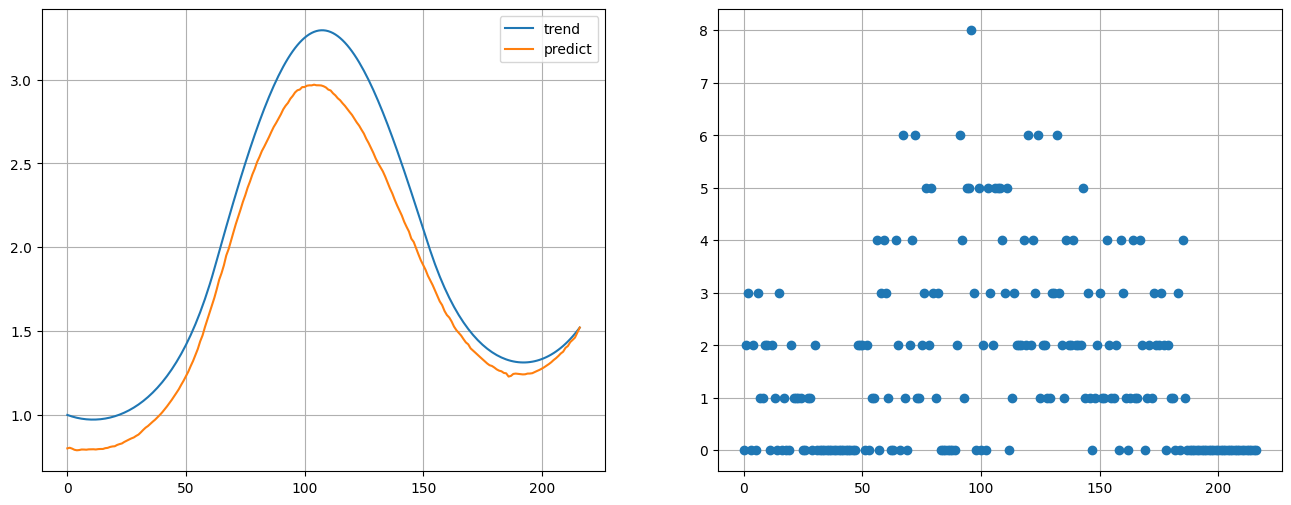

In [34]:
x, y, params, lam, k = sim_data(batch=1)
output = model(x).detach().squeeze()
y = y.detach().squeeze()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(y)
ax1.plot(output / output[-1] * y[-1])
ax1.legend(["trend", "predict"])
ax1.grid(True)
ax2.grid(True)
ax2.plot(x.squeeze()[:, 2], "o");

Сравнение результата основанном на нейронной сети с baseline решением

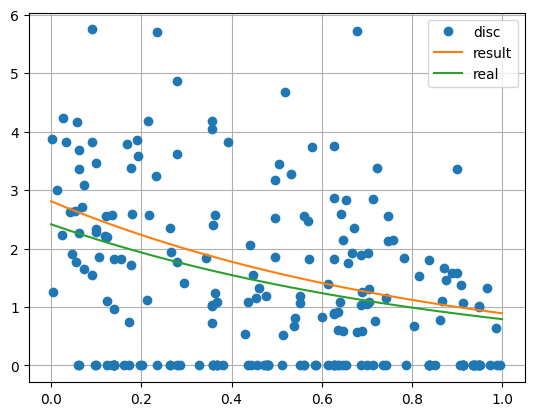

In [35]:
xx = np.linspace(0, 1)
order = x[:, :, 2].squeeze().numpy()
price = x[:, :, 1].squeeze().numpy()
discount = order / output.numpy() * output.numpy()[-1]
plt.plot(price, discount, "o")
B = (x[:, :, 0] == 1).squeeze()
b = get_stat(price[B], discount[B])
z = np.exp(b[0] + xx * b[1])
Z = np.exp(params[1] - xx * params[0] + np.log(k[-1]))
plt.plot(xx, z)
plt.plot(xx, Z)  # *k[-1]
plt.legend(["disc", "result", "real"])
plt.grid(True)

In [37]:
market = BaseLine(params = ['exp', [-0.03, -0.001], [0.2, 6]], num_point=20, num_level=10,
                 trend = 1, seasonality = (1,0.3,0.5), period = 365)